# 3.1 Motor de Indução - Estimador de Parâmetros

Nesta atividade iremos utilizar o conceito de estimador de parâmetros aplicado a motores de indução. Nosso estudo é baseado no artigo "análise paramétrica de motores energeticamente eficientes", disponível na pág. 34 da edição de Maio de 2018 da Eletricidade Moderna [Bortoni et al. (2018)](https://www.arandanet.com.br/revista/em/edicao/2018/maio). Uma problemática normalmente vivida por um engenheiro é: eu até sei a teoria, conheço ou posso aprende softwares pra simular uma aplicação, mas como eu descubro os parâmetros para utilizar no modelo?

Estude o artigo e veja abaixo um exemplo de implementação do algoritmo proposto no artigo.  

## Levantamento de dados

Primeiro passo é tomar os dados do fabricante por meio do datasheet fornecido pelo fabricante [WEG](http://catalogo.weg.com.br). 

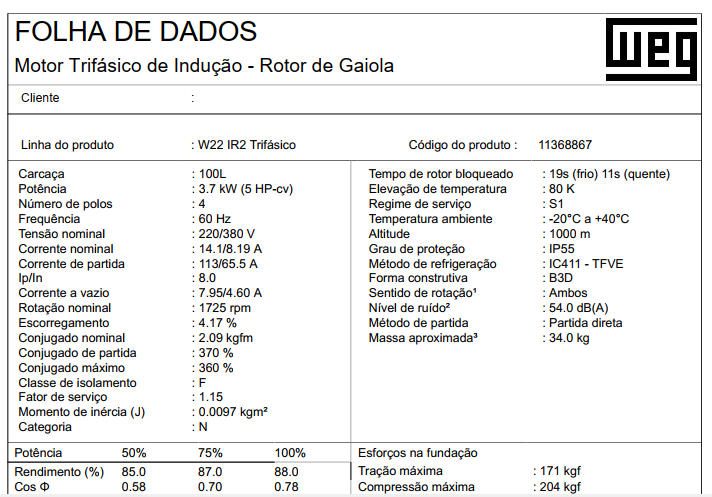

Insira os novos dados utilizados abaixo:

In [1]:
Mst_r = 3.7; %relação conjugado de partida/nominal
Mk_r = 3.6; %relação conjugado máx/nominal
Ist_r = 8; %relação corrente de partida/nominal
ns = 1800; %velocidade sincrona
nr = 1725; %velocidade nominal
FP = 0.78; %Fator de potência plena carga
Pn = 3700;
In = 8.19; Vl = 380; %corrente e tensão nominal de linha (380 V)
tn = 20.5; % torque nominal [Nm]

## Modelo Elétrico do Motor de Indução

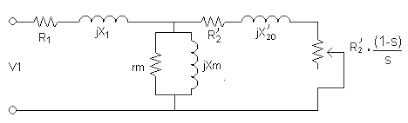

## Extração dos dados do catálogo do fabricante

Para estimação das curvas da resistência do estator e do rotor são necessárias as curvas de potência, eficiência, escorregamento e corrente. Extraia 10 pontos (com exceção do 0) - fique a vontade para utilizar auxílio, como o [WebPlotDigitizer 4.4](https://apps.automeris.io/wpd/).

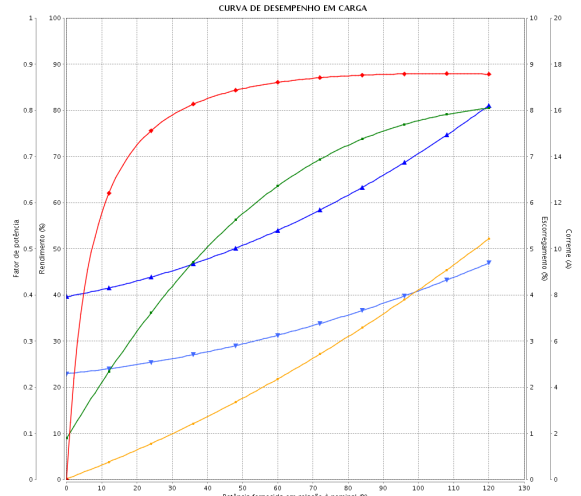

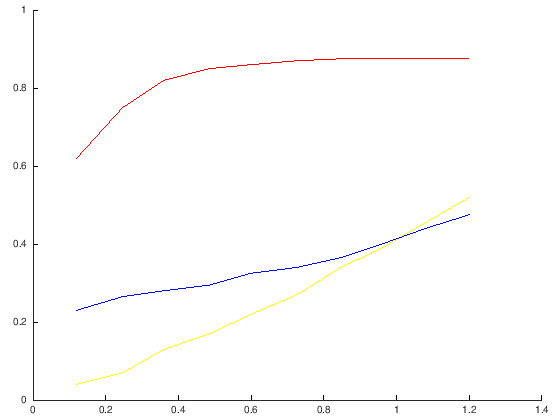

In [7]:
% Iportante: todos os valores tem que ser para os mesmos valores de potência no gráfico
P2 = Pn*[0.12 0.246667 0.36 0.486667 .60 0.726667 0.846667 0.96 1.08 1.2]; %Potência
Eff =[62 75 82 85 86 87 87.5 87.7 87.7 87.5]; %Eficiência
s =[0.4 0.7 1.3 1.7 2.2 2.7 3.4 3.9 4.55 5.2]; %Escorregamento
I1 =[  4.6 5.3 5.6 5.9 6.5 6.8 7.3 8 8.8 9.5 ]; %Corrente
hold on
plot(P2/Pn,Eff/100,'r') % 100 é o máximo mostrado no gráfico do fabricante
plot(P2/Pn,s/10,'y') % 10 é o máximo mostrado no gráfico do fabricante
plot(P2/Pn,I1/20,'b') % 20 é o máximo mostrado no gráfico do fabricante
% Compare com os dados do fabricante se os gráficos ficaram parecidos


# Algoritmo

Em toda condição de operação, existe um equilíbrio no motor no qual a energia eletromagnética é o resultado da subtração, em relação à energia de entrada, das perdas rotacionais e das perdas no cobre do estator (BORTONI, 2018).

$\frac{P_{2}}{Eff} - \frac{P_{2}}{1-s} = 3r_{1}I_{1}^{2} + P_{rot}$

Desta maneira, é possível estimar a inclinação $r_{1}$ e as perdas na rotação $P_{rot}$ por meio de um ajuste linear, portanto calculamos:

In [3]:
%Resistências
yr1 = P2*100./Eff - P2*100./(100-s); %Estimação da inclinação (R1)
xr1 = 3*I1.^2;

%minimização do erro quadrático (pseudo-inversão)

A = [xr1'  ones(length(xr1),1)];
C = pinv(A)*yr1'; YR1=C(1)*xr1+C(2);
r1 = C(1); Prot = C(2);



De moto similar podemos estimar a resistência do rotor vista do estator a partir do seguinte balanço de potências:

$\frac{P_{2} * s}{1-s} = 3r_{2}I_{2}^{2} + K $



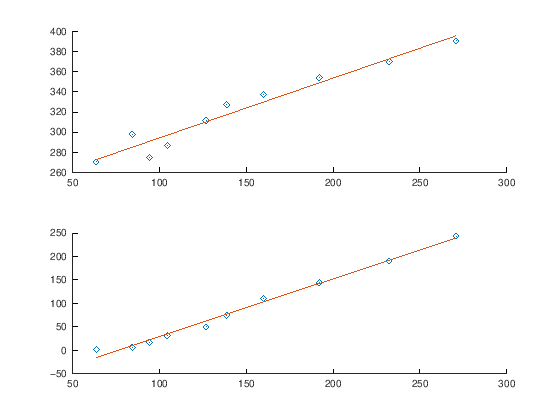

In [4]:
 %Estimação da inclinação (R2)
yr2_= P2.*(s./(100-s));xr2_=xr1;
%minimização do erro quadrático (pseudo-inversão)
A = [xr2_'  ones(length(xr2_),1)];
C2 = pinv(A)*yr2_'; YR2 = C2(1)*xr2_+C2(2);
r2 = C2(1);

%Plot
figure(2)
subplot(2,1,1) % Em vermelho a reta que estima R1
hold on
plot(xr1,yr1,'d')
plot(xr1,YR1)

subplot(2,1,2)
hold on

plot(xr2_,yr2_,'d') % Em vermelho a reta que estima R2'
plot(xr2_,YR2)

Estimação dos demais parâmetros com base no artigo de Bertoni et al (2018).

In [5]:
sr = (ns-nr)/ns;                                   % escorregamento nominal
sk = sr*(Mst_r + sqrt(Mst_r^2-1));                 % escorregamento durante o conjugado máximo
I2 = I1*FP*sqrt(1+(sr/sk)^2);                      % Cálculo da corrente do rotor baseada no fator de potência
r_20 = (1/3)*(ns/nr)*(Mst_r*P2/(Ist_r*I2).^2);     % resistência do rotor durante a partida
gr = log(r_20/r2)/(sqrt(1-sr));                   % Fator de variação da resistência do rotor 
r_2k = r_20*exp(gr*sqrt(1-sk));                    % resistência do rotor durante o conjugado máximo
xs = sqrt((Vl/(Ist_r*In))^2 - (r1+r_20)^2);        % reatância de curto circuito
x1 = (0.6 - 0.3*Mst_r/Mk_r)*xs;                    % reatância de dispersão do estator
x_20 = xs - x1;                                    % reatância do rotor na partida
x_2k = r_2k/sk;                                    % reatância do rotor no conjugado máximo
gx = log(x_20/x_2k)/sqrt(1-sk);                    % fator de variação da reatância
x2= x_20*exp(gx*sqrt(1-sr));                       % reatância de dispersão do rotor referenciada do estator

In [6]:
%parâmetros de magnetização

E = Vl - In*(r1^2 + x1^2)^0.5;                     % Tensão sobre o ramo de magnetização
rm = (E^2)/Prot;                                   % Resistência de magnetização 
In2 = In*FP*sqrt(1+(sr/sk)^2);                     % Corrente do rotor em plena carga
xm = E/sqrt(In^2-In2^2-(E/rm)^2);                  % Reatância de magnetização

% Display
sprintf('Resistência Estator (r1): %.4f ; Reatância Estator (x1): %.4f;', r1, x1) 
sprintf('Resistência Rotor (r2"): %.4f ; Reatância do Rotor (x2"): %.4f;', r2,x2)
sprintf('Resistência Magnetização (rm): %.4f ; Reatância de Magnetização: %.4f;', rm, xm)

ans = Resistência Estator (r1): 0.5944 ; Reatância Estator (x1): 1.5576;
ans = Resistência Rotor (r2"): 1.2296 ; Reatância do Rotor (x2"): 1.7937;
ans = Resistência Magnetização (rm): 571.4782 ; Reatância de Magnetização: 73.1489;


# Curva Característica: Torque-Velocidade

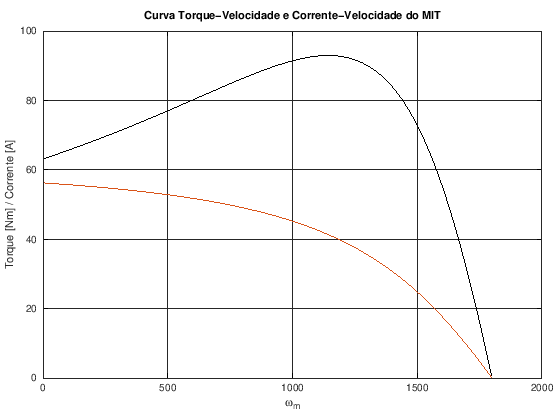

In [10]:
ws = ns*2*pi/60; % velocidade síncrona angular (rad/s)
% Calculando a tensão e impedância de Thevenin
% Desconsiderando rm, verifique que a diferença é pequena
%v_th = Vl / sqrt(3) * ( xm / sqrt(r1^2 + (x1 + xm)^2) );
%z_th = j*xm * (r1 + j*x1) / (r1 + j*(x1 + xm));
% Considerando rm
v_th = Vl / sqrt(3) / ((1 + r1/rm + x1/xm) + j*(x1/rm-r1/xm));
z_th = (r1 + j*x1) / ((1 + r1/rm + x1/xm) + j*(x1/rm-r1/xm));
r_th = real(z_th);
x_th = imag(z_th);
s = (0:1:500) / 500; % escorregamento
s(1) = 0.001;
nm = (1 - s) * ns; % velocidade angular
% Calcular o torque
for ii = 1:501
t_m(ii) = (3 * v_th^2 * r2 / s(ii)) / ...
(ws * ((r_th + r2/s(ii))^2 + (x_th + x2)^2) );
end
Ir=v_th./(sqrt(((r2./s)+r1).^2+(x1+x2)^2));
% Plotar a curva torque-velocidade
plot(nm,t_m,'Color','k','LineWidth',2.0);
hold on;
grid on;
plot(nm,Ir);
ylabel('Torque [Nm] / Corrente [A]');
xlabel('\omega_m');
title('Curva Torque-Velocidade e Corrente-Velocidade do MIT');
hold off;

## Comparando com o Catálogo

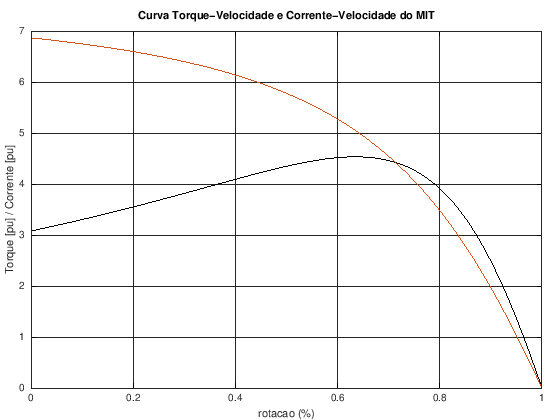

In [11]:
% Plotar a curva torque-velocidade
plot(1-s,t_m/tn,'Color','k','LineWidth',2.0);
hold on;
grid on;
plot(1-s,Ir/In);
ylabel('Torque [pu] / Corrente [pu]');
xlabel('rotacao (%)');
title('Curva Torque-Velocidade e Corrente-Velocidade do MIT');
hold off;

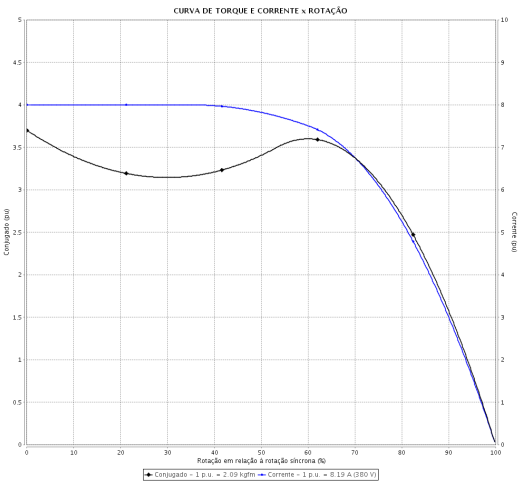

# Curva velocidade-eficiência
variando o escorregamento

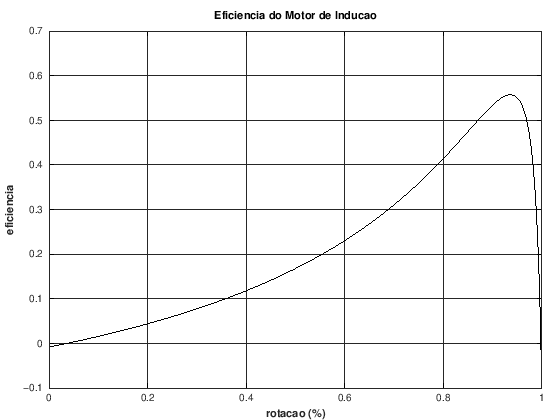

In [12]:
vf = Vl / sqrt(3); % tensão de fase
nm = (1 - s) * ns; % velocidade angular do motor
for ii = 1:501
z_s(ii) = r1+(x1); %impedância do estator
z_r(ii) = (r2/s(ii))+(x2); %impedância do rotor
z_m(ii) = xm ; %impedância de magnetização
z_eq(ii) = z_s(ii)+((z_m(ii)*z_r(ii))/(z_m(ii)+z_r(ii))); %impedância equivalente
i_s(ii) = vf/z_eq(ii) ; %corrente no estator
p_in(ii) = 3*vf*(real(i_s(ii))); %potência de entrada
e_s(ii) = vf-(i_s(ii)*z_s(ii));
i_r(ii) = e_s(ii)/z_r(ii); %corrente no rotor
p_conv(ii) = 3*(((abs(i_r(ii)))^2)*((r2)*((1-s(ii))/(s(ii)))));
p_out(ii) = ((p_conv(ii))); %potência de saída
eff(ii) = (p_out(ii))/(p_in(ii)); %eficiência
end
% Plotar a curva velocidade-eficiência
plot(1-s,eff,'Color','k','LineWidth',2.0);
hold on;
xlabel('rotacao (%)','Fontweight','Bold');
ylabel('eficiencia','Fontweight','Bold');
title ('Eficiencia do Motor de Inducao','Fontweight','Bold');
grid on;
hold off;

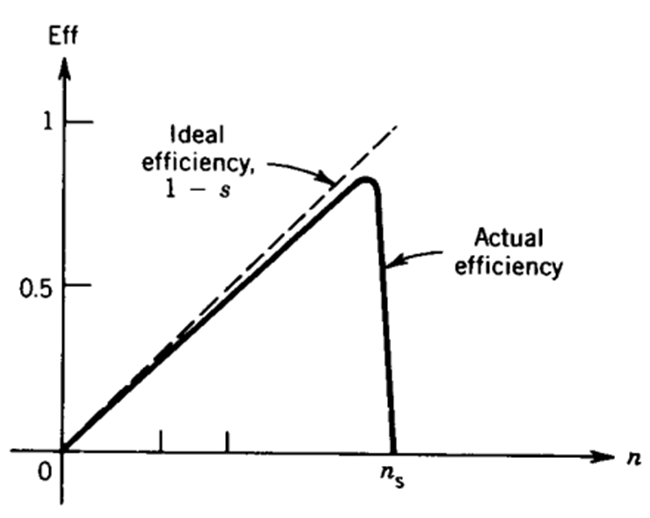

Fonte: Sen - Principles of electric machines and power electronics – pag. 239

# Agradecimento

Meus agradecimentos ao mestrando José Jorge de Oliveira Neto, pela implementação do código.

# Referências

https://paginas.fe.up.pt/maquel/AD/MI_model.pdf

https://www.mathworks.com/matlabcentral/fileexchange/60260-induction-motor-slip-characteristic?s_tid=srchtitle

# Tarefa

Para isso, devemos acessar o site do fabricante em busca dos dados do motor: selecione dois motores trifásicos de indução disponíveis no site da [WEG](http://catalogo.weg.com.br). Assim como no exemplo do arquivo anterior, Será preciso utilizarmos a folha de dados e o gráfico "Curva de desempenho em carga". Para auxiliar na tomada dos pontos, utilize o [WebPlotDigitizer 4.4](https://apps.automeris.io/wpd/). Em seguida, execute o código com os novos dados inseridos para estimar os valores do novo motor.